# 2. Feature Engineering

Second attempt at building a model to predict house prices. 

In [30]:
import os
import platform
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Check which platform is running the notebook
if platform.system() == 'Windows':
    PROJECT_PATH = "\\".join(os.getcwd().split('\\')[:-1])
else:
    # Assuming a Unix based platform
    PROJECT_PATH = "/".join(os.getcwd().split('/')[:-1])

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train.csv')

# Load the training dataset
house_prices_train = pd.read_csv(TRAIN_DATA_PATH)
house_prices_train = house_prices_train.drop('Id', axis=1)
house_prices_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Split into training and testing set

In [31]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
test_size = 0.3
target_feature = 'SalePrice'

X = house_prices_train.drop(target_feature, axis=1)
y = house_prices_train[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=test_size)

In [32]:
def remove_missing_features(X, threshold=0.8, verbose=False):
    features = X.columns
    features_to_remove = []
    dataset_size = X.shape[0]
    for f in features:
        missing_count = X[X[f].isna()].shape[0]
        missing_ratio = missing_count / dataset_size
        if missing_ratio > threshold:
            features_to_remove.append(f) 
            if verbose:
                print("{:14}{:.3f}%".format(f, missing_ratio * 100))
    return X.drop(features_to_remove, axis=1)

X_train_df = remove_missing_features(X_train, threshold=0.5, verbose=True)

Alley         93.542%
PoolQC        99.511%
Fence         80.235%
MiscFeature   96.086%


## Remove Features with a single value and highly correlated features

In [33]:
def remove_single_values(X, verbose=False):
    features = X.columns
    features_to_remove = []
    for f in features:
        value_count = X[f].nunique()
        if value_count == 1:
            features_to_remove.append(f)
            if verbose:
                print('Removing ', f)
    return X.drop(features_to_remove, axis=1)

def remove_highly_correlate_features(X, threshold=0.9):
    corr = X.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_remove = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_remove, axis=1)

X_train_df = remove_single_values(X_train_df)
X_train_df = remove_highly_correlate_features(X_train_df)

## Remove target feature outliers

In [34]:
quantiles = y_train.quantile([0.25, 0.75]).values

# Q1 at index 0 and Q3 at index 1
iqr = quantiles[1] - quantiles[0]
outlier_threshold = quantiles[1] + (1.5 * iqr)
outlier_threshold

342500.0

In [35]:
feature_inliers_indices = np.where(y_train < outlier_threshold)[0]

# Extract the inliers from the dataset
X_train_df = X_train_df.iloc[feature_inliers_indices]
y_train = y_train.iloc[feature_inliers_indices]

# Validate they are the same size 
assert X_train_df.shape[0] == y_train.shape[0]

## Feature Engineering


### Numeric Features

In [36]:
X_train_df.shape

(981, 75)

In [37]:
numeric_features = X_train_df.select_dtypes(['int64', 'float64'])
numeric_features.shape

(981, 36)

In [38]:
numeric_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [39]:
numeric_cols = numeric_features.columns.tolist()

Creating new features:

In [40]:
overall_score = (numeric_features.OverallQual + numeric_features.OverallCond) / 2

In [41]:
upper_total_ft = numeric_features['1stFlrSF'] + numeric_features['2ndFlrSF']

In [42]:
future_garage = (numeric_features.GarageYrBlt == numeric_features.YearBuilt).astype(int)

In [43]:
build_in_20_centry = (numeric_features.YearBuilt < 2000).astype(int)
build_in_20_centry.value_counts()

1    734
0    247
Name: YearBuilt, dtype: int64

In [44]:
had_changes = (numeric_features.YearBuilt != numeric_features.YearRemodAdd).astype(int)
had_changes.value_counts()

0    516
1    465
dtype: int64

### Categorical Features

In [45]:
categorical_features = X_train_df.select_dtypes(['object'])
categorical_features.shape

(981, 39)

In [46]:
categorical_cols = categorical_features.columns
categorical_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

Get the ordinal features

In [47]:
# Define the ordinal features
ordinal_cols = [
    'LotShape',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageQual',
    'GarageCond',
]

# Extract the categorical features from the ordinal features
categorical_cols = categorical_cols[~categorical_cols.isin(ordinal_cols)]

## Processing the data

In [48]:
from sklearn.model_selection import cross_val_score

def cross_val_regression(clf, X, y, cv=3):
    neg_mse_scores = cross_val_score(clf, X, y, scoring='neg_mean_squared_error', cv=cv)
    neg_log_scores = cross_val_score(clf, X, y, scoring='neg_mean_squared_log_error', cv=cv)
    return {
        'rmse': (np.sqrt(-neg_mse_scores)).mean(),
        'rmlse': (np.sqrt(-neg_log_scores)).mean()
    }

In [49]:
from sklearn.base import TransformerMixin

class CreateNumericFeatures(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        overall_score = (numeric_features['OverallQual'] + numeric_features['OverallCond']) / 2
        upper_total_ft = numeric_features['1stFlrSF'] + numeric_features['2ndFlrSF']
        future_garage = (numeric_features['GarageYrBlt'] == numeric_features['YearBuilt']).astype(int)
        build_in_20_centry = (numeric_features['YearBuilt'] < 2000).astype(int)
        had_changes_made = (numeric_features['YearBuilt'] != numeric_features['YearRemodAdd']).astype(int)
        X.drop(['OverallQual', 'OverallCond', '1stFlrSF', '2ndFlrSF', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'], axis=1)
        X['OverallScore'] = overall_score
        X['UpperFlrSF'] = upper_total_ft
        X['GarageLater'] = future_garage
        X['BuildIn20Centuary'] = build_in_20_centry
        X['Remodelled'] = had_changes_made
        return X
    

class CombineGarageFeatures(TransformerMixin):
    def __init__(self):
        self.ratings = {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1,
            'NA': 0
        }
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        convert_rating = lambda x : self.ratings.get(x, 0) 
        garage_qual = X['GarageQual'].apply(convert_rating)
        gargage_condition = X['GarageQual'].apply(convert_rating)
        garage_rating = (garage_qual + gargage_condition) / 2
        X['GarageRating'] = garage_rating
        X.drop(['GarageQual', 'GarageQual'], axis=1)
        return X
    
    
class ExteriorCondition(TransformerMixin):
    def __init__(self):
        self.ratings = {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1
        }
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        convert_rating = lambda x : self.ratings.get(x, 0) 
        exterior_qual = X['ExterQual'].apply(convert_rating)
        exterior_condition = X['ExterCond'].apply(convert_rating)
        exterior_rating = (exterior_qual + exterior_condition) / 2
        X['ExterRating'] = exterior_rating
        X.drop(['ExterQual', 'ExterCond'], axis=1)
        return X

In [50]:
numeric_cols = [
     'MSSubClass',
     'LotFrontage',
     'LotArea',
     'MasVnrArea',
     'BsmtFinSF1',
     'BsmtFinSF2',
     'BsmtUnfSF',
     'TotalBsmtSF',
     'LowQualFinSF',
     'GrLivArea',
     'BsmtFullBath',
     'BsmtHalfBath',
     'FullBath',
     'HalfBath',
     'BedroomAbvGr',
     'KitchenAbvGr',
     'TotRmsAbvGrd',
     'Fireplaces',
     'GarageCars',
     'GarageArea',
     'WoodDeckSF',
     'OpenPorchSF',
     'EnclosedPorch',
     '3SsnPorch',
     'ScreenPorch',
     'PoolArea',
     'MiscVal',
     'MoSold',
     'YrSold',
     'OverallScore',
     'UpperFlrSF',
     'GarageRating',
     'ExterRating',
     'BuildIn20Centuary',
     'Remodelled'
]

categorical_features = [
    'LotShape',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu'
]

In [51]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p))
])

ordinal_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])


processing_pipeline = Pipeline([
    ('numeric_features', CreateNumericFeatures()),
    ('garage', CombineGarageFeatures()),
    ('extorior', ExteriorCondition()),
    ('processing', ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_cols),
        ('ordinal', ordinal_pipeline, ordinal_cols),
        ('categorical', categorical_pipeline, categorical_cols.tolist())
    ]))
])

In [52]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def root_mean_log_error(y_true, y_pred):
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except ValueError:
        return -1000

## Creating a baseline before Feature Engineering

In [53]:
X_train_processed = processing_pipeline.fit_transform(X_train_df)

In [54]:
X_train_processed.shape

(981, 221)

In [55]:
from sklearn.ensemble import RandomForestRegressor

rand_forest_baseline = RandomForestRegressor(random_state=RANDOM_STATE)
scores = cross_val_regression(rand_forest_baseline, X_train_processed, y_train)

In [56]:
print('Baseline Random Forest RMLSE: {:.3f}'.format(scores['rmlse']))
print('Baseline Random Forest RMSE: {:.3f}'.format(scores['rmse']))

Baseline Random Forest RMLSE: 0.145
Baseline Random Forest RMSE: 22901.261


From applying some feature generation and seperating the categorical and ordinal data, we can see a improvement compared to the best baseline model from the previous notebook

### Feature Importance

In [57]:
rand_forest_baseline.fit(X_train_processed, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [76]:
categorical_one_hot_features = processing_pipeline['processing'].transformers_[2][1]['one_hot'].categories_
categorical_one_hot_features = np.concatenate(categorical_one_hot_features)
categorical_one_hot_features

baseline_features = np.asarray(numeric_cols + ordinal_cols)
baseline_features = np.concatenate([baseline_features, categorical_one_hot_features])
baseline_features.shape

(221,)

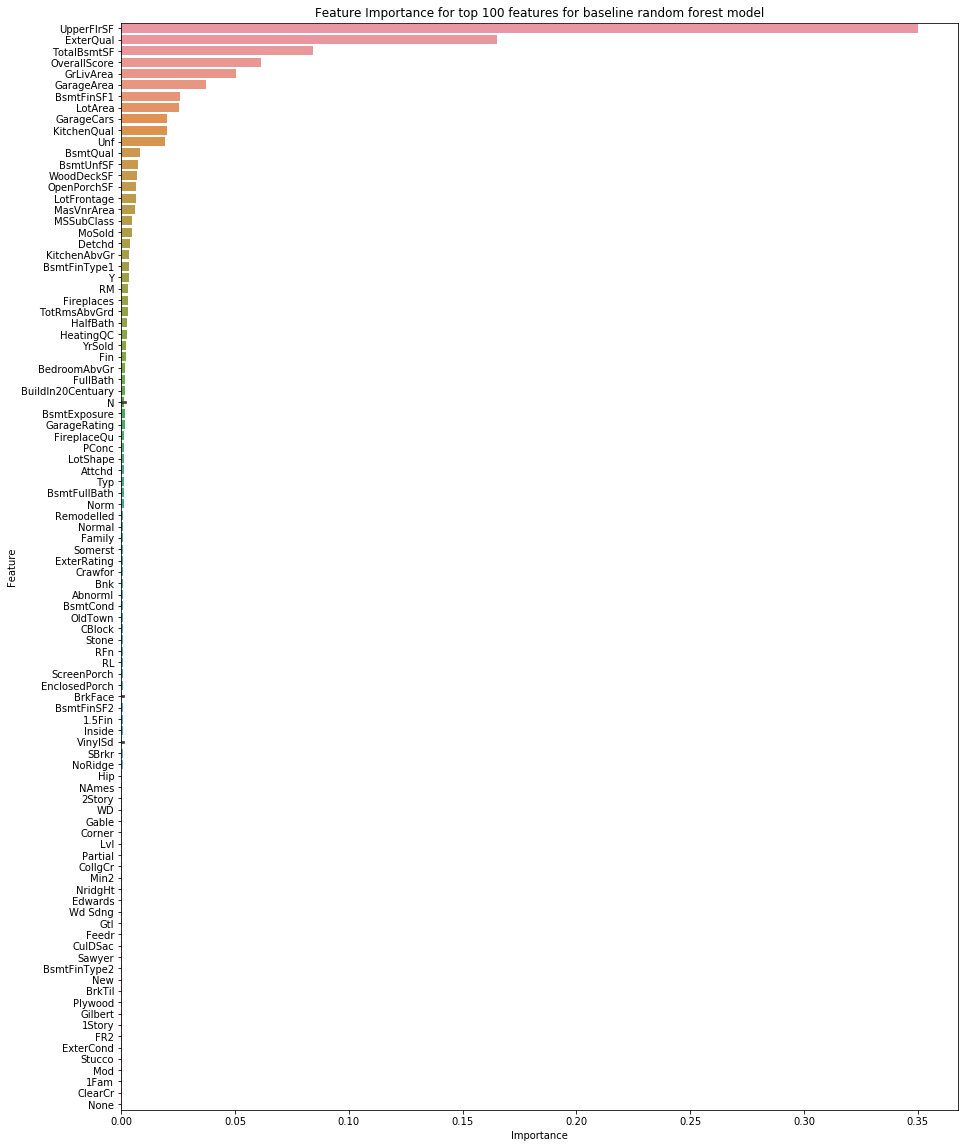

In [95]:
baseline_features_importance = rand_forest_baseline.feature_importances_
top_100_features_indices = np.argsort(baseline_features_importance)[::-1][:100]

plt.figure(figsize=(15, 20))
sns.barplot(baseline_features_importance[top_100_features_indices], baseline_features[top_100_features_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for top 100 features for baseline random forest model')
plt.show()

Create a new random forest model based on the top 20 features

In [99]:
top_20_feature_indices = top_100_features_indices[:20]

X_train_top_20_features = X_train_processed[:, top_20_feature_indices]
X_train_top_20_features.shape

(981, 20)

In [100]:
rand_forest_top_20_features = RandomForestRegressor(random_state=RANDOM_STATE)
scores = cross_val_regression(rand_forest_top_20_features, X_train_top_20_features, y_train)

print('Random Forest Top 20 Features RMLSE: {:.3f}'.format(scores['rmlse']))
print('Random Forest Top 20 Features RMSE: {:.3f}'.format(scores['rmse']))

Random Forest Top 20 Features RMLSE: 0.147
Random Forest Top 20 Features RMSE: 22991.819


Results are more or less the same as the previous baseline, so we are seeing a significant improvement already compared to the original baseline.